<a href="https://colab.research.google.com/github/garrettsomers/ManningLLMBook/blob/chapter5/notebooks/Chapter5_RLHF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using RLHF to generate more helpful responses


In this tutorial, we will demonstrate how Reinforcement Learning with Human Feedback (RLHF) can be used to fine-tune a generative language model. We use a set of prompts that reflect various ways that a human might potentially interact with a chatbot, along with a separate reward model that rates the quality of the generated answers. The reward model outputs are then used to update the weights of the LM through the PPO algorithm. The end result is an updated version of the LM that has been optimized to receive consistently higher returns from the reward model.

The methods outlined here are a reflection of key advancements that brought generative AI into the mainstream and stimulated a massive wave of investment. Before RLHF came into prominence with results such as InstructGPT, state-of-the-art LLM's were capable of producing realistic prompt answers with appropriate grammatical usage and accurate factual knowledge. However, these responses often were not well-suited for addressing a problem or completing a task in a useful manner. With the addition of RLHF, LLM's have gained the ability to align their outputs more closely to the intentions of their users. This has opened the door to many new applications that require more human-like interactions than chatbots and virtual assistants were previously capable of. It has also become a major contributor to the latest efforts in AI safety. Bai et al. (2022) did extensive work toward the ideal of "helpful, honest, and harmless" LLM interactions developed through RLHF.

Since RLHF is a very expensive process, in terms of human effort as well as compute resources, the experiment provided in this tutorial follows a much shorter and simpler training process than what would be required to see truly impressive results. But even this small-scale exercise is sufficient to demonstrate how these techniques have been very effective when employed at a much larger scale.


### Setup environment

In [ ]:
!pip install accelerate -U

In [ ]:
%load_ext autoreload
%autoreload 2

%pip install transformers trl evaluate

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

### Import dependencies

In [ ]:
import torch
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from IPython.display import Image, display_png, clear_output
import numpy as np

tqdm.pandas()

from transformers import pipeline, AutoTokenizer
from datasets import load_dataset

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

### Configuration

In [ ]:
config = PPOConfig(
    model_name="aisquared/dlite-v1-355m",
    batch_size=16
)


### Load data

The dataset used in this tutorial was made available by Anthropic (with the paper - need to reread and describe in more detail). It consists of manually written prompts representing human inputs, with two possible answers coming from a virtual assistant. The two answers have been reviewed by humans, and in each case one was chosen as being more helpful than the other.

For our purposes, we will not be training our own reward model. Instead we will extract the prompts from the text and use them in the RL training loop. Repurposing this data allows us to sidestep the very expensive and difficult initial step of prompt creation. Organizations such as OpenAI generally have two main sources for these types of prompts:
- High-skill contractors who carefully craft prompts and answers, which the model can use to learn how to emulate what a human response looks like.
- Online data, meaning that queries submitted by users to an existing model are captured. In some cases, those users may also have the option of indicating whether or not they like the response, which can be even more beneficial to the RLHF fine-tuning process.

In [ ]:
ds = load_dataset("Anthropic/hh-rlhf", data_dir="helpful-base", split="train")
print(ds)

# create prompts by chopping off the Assistant response in the dataset
new_col = [x[len("\n\nHuman: "):x.find("Assistant:")]
           for x in ds["chosen"]]
new_col = [x.replace("\n", " ").strip() for x in new_col]
ds = ds.add_column("instruction", new_col)
ds = ds.filter(lambda x: len(x["instruction"]) < 100)
ds = ds.select(range(6400))

examples = ds.select((0, 1))
print(examples["instruction"])

Dataset({
    features: ['chosen', 'rejected'],
    num_rows: 43835
})


['Hi, I want to learn to play horseshoes. Can you teach me?', 'How do I teach kids to meditate?']


The DLite model uses special tokens, so we will need to format our prompts accordingly.

In [ ]:
INSTRUCTION_KEY = "### Instruction:"
RESPONSE_KEY = "### Response:"
END_KEY = "### End"
INTRO_BLURB = (
    "Below is an instruction that describes a task. Write a response that appropriately completes the request."
)

# This is the prompt that is used for generating responses using an already trained model.  It ends with the response
# key, where the job of the model is to provide the completion that follows it (i.e. the response itself).
PROMPT_FOR_GENERATION_FORMAT = """{intro}
{instruction_key}
{instruction}
{response_key}
""".format(
    intro='',
    instruction_key=INSTRUCTION_KEY,
    instruction="{instruction}",
    response_key=RESPONSE_KEY,
)

In [ ]:
ds = ds.add_column('query', [PROMPT_FOR_GENERATION_FORMAT.format(instruction=i) for i in ds['instruction']])
ds.select((0, 1))['query']

['\n### Instruction:\nHi, I want to learn to play horseshoes. Can you teach me?\n### Response:\n',
 '\n### Instruction:\nHow do I teach kids to meditate?\n### Response:\n']

### Supervised fine-tuning

Supervised fine-tuning (SFT) is another step that we are skipping. Technically this is not requisite for reinforcement learning, but it is often done to precondition the model prior to the actual RL training process. In this step, we would directly use the human-written responses described above to fine-tune the model in the direction of more human-like text generation.

This is usually considered to be an optional step, mostly because it necessitates a great deal of manual effort that is only accessible in large tech companies with massive AI budgets. It's much less expensive to have the model produce all of the answers and only use humans to perform the much simpler task of ranking the quality of the outputs. This in fact is the next step in the RLHF process, regardless of whether or not SFT is performed.

### Tokenize

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
tokenizer.pad_token = tokenizer.eos_token

def tokenize(sample):
    sample["input_ids"] = tokenizer.encode(sample["query"])
    sample["query"] = sample['instruction']
    return sample

dataset = ds.map(tokenize, batched=False)
dataset.set_format(type="torch")
dataset.shape

(6400, 5)

### Load pre-trained DLite model

The RLHF process begins with an existing pre-trained model. Here we are using DLite, since it is relatively small and can be fine-tuned with limited GPU usage. A larger model would generate significantly better responses, but the reinforcement learning mechanics still operate in much the same way.

In [ ]:
model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)

### Load reward model

The next step is training a reward model. The reward model's objective is to score a given prompt/answer pair according to how favorably a human would judge the answer. To train this model, we could use a dataset very similar to the one already described. In some cases, rather than only having two answers to compare, the original LLM is instead asked to produce several possible answers. Human annotators must then rank them from best to worst, very much like what is represented as the "chosen" and "rejected" columns in the Anthropic dataset. This data is then used to train the reward model.

For this tutorial, we'll avoid spending time training a reward model and simply download a popular one from HuggingFace.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

reward_name = "OpenAssistant/reward-model-deberta-v3-large-v2"
reward_model = AutoModelForSequenceClassification.from_pretrained(reward_name)
reward_tokenizer =  AutoTokenizer.from_pretrained(reward_name)

question = "How do I teach kids to meditate?"
helpful = "I'm glad you want to teach your kids about meditation!"
bad = "I am not able to answer this question."

inputs = reward_tokenizer(question, helpful, return_tensors='pt')
good_score = reward_model(**inputs).logits[0].cpu().detach()

inputs = reward_tokenizer(question, bad, return_tensors='pt')
bad_score = reward_model(**inputs).logits[0].cpu().detach()
print(good_score, bad_score)


tensor([-2.0916]) tensor([-3.8319])


The example above shows that the reward model is giving a higher score to a more helpful response, so our hope is that we can train a more helpful model by encouraging it to generate responses with higher rewards.

### Training loop

Now it's time to do reinforcement learning. We'll run PPO using the reward model as the basis for the reward function. The PPO trainer is initialized with two copies of the generative LLM. One will remain frozen for use as a reference, while the other will be the initial policy that's iteratively trained with PPO. The resulting policy after training is a new version of the generated model with the weights optimized for better human ratings. In each iteration of the training loop, the following steps occur:
1. A batch of prompts is passed through both the policy LLM and the frozen copy.
2. The responses from the policy are fed into the reward model to score their quality.
3. Gradient descent is used to update the weights with the objective of maximizing the reward. Note that the reward model is typically not an adequate reward function on its own. The construction of the reward function is an active area of research, but it almost always includes KL divergence between the updated policy and the original reference LLM. The goal is to ensure that the policy doesn't overfit to the reward model and forget too much information that it had previously learned.

In [ ]:
gen_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "eos_token_id": tokenizer.encode(END_KEY)
}

In [ ]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

ppo_trainer = PPOTrainer(config, model, ref_model, tokenizer, dataset,
                         data_collator=collator)

In [ ]:
use_cuda = torch.cuda.is_available()

device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if use_cuda else "cpu"
    
if use_cuda:
    reward_model = reward_model.cuda()

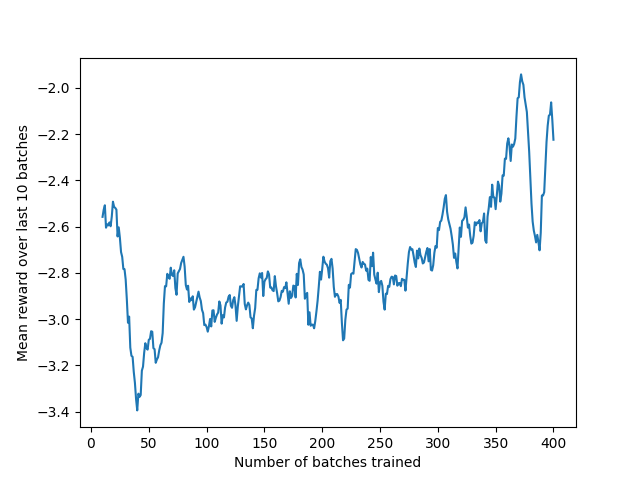

400it [1:44:06, 15.62s/it]

What does feather in a cap mean In a feather in a cap is a type of artificial feather or string that is


In [ ]:
%matplotlib notebook

# initialize notebook
plt.ion()
fig, ax = plt.subplots()
xs = []
moving_avg = []

for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    query_tensors = batch["input_ids"]

    #### Get response from dlite
    response_tensors = []
    for query in query_tensors:
        gen_len = 16
        response = ppo_trainer.generate(query, max_new_tokens=gen_len, **gen_kwargs)
        response_tensors.append(response.squeeze()[-gen_len:])
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    inputs = reward_tokenizer(batch["query"], batch["response"], return_tensors="pt", padding=True)
    inputs = inputs.to(device)
    rewards = reward_model(**inputs).logits.cpu().detach()
    rewards = [r[0] for r in rewards]

    #### Run PPO step
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    xs.append(stats["ppo/mean_scores"])

    if epoch < 9:
        continue

    moving_avg.append(np.mean(xs[-10:]))

    ax.clear()
    ax.plot(range(10, epoch+2), moving_avg)

    ax.set_xlabel("Number of batches trained")
    ax.set_ylabel("Mean reward over last 10 batches")
    io = BytesIO()
    fig.savefig(io, format="png")

    clear_output(wait=True)
    display_png(Image(io.getvalue()))

    print(batch["query"][0], batch["response"][0])


In [ ]:
# push model to hub for easier evaluation

MODEL_NAME = 'Name your model for HF Hub'

model.push_to_hub(MODEL_NAME)

### Model inspection

In [ ]:
#### get a batch from the dataset
bs = 16
test_data = dict()
dataset.set_format("pandas")
df_batch = dataset[:].sample(bs)
test_data["query"] = df_batch["query"].tolist()
query_tensors = df_batch["input_ids"].tolist()

response_tensors_ref, response_tensors = [], []

#### get response from both original and new dlite
for i in range(bs):
    gen_len = 16
    # gen_len = output_length_sampler()
    output = ref_model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device), max_new_tokens=gen_len, **gen_kwargs
    ).squeeze()[-gen_len:]
    response_tensors_ref.append(output)
    output = model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device), max_new_tokens=gen_len, **gen_kwargs
    ).squeeze()[-gen_len:]
    response_tensors.append(output)

#### decode responses
test_data["response (before)"] = [tokenizer.decode(response_tensors_ref[i]) for i in range(bs)]
test_data["response (after)"] = [tokenizer.decode(response_tensors[i]) for i in range(bs)]

inputs = reward_tokenizer(test_data['query'], test_data['response (before)'], return_tensors='pt', padding=True)
inputs = inputs.to(device)
test_data["rewards (before)"] = [r[0] for r in reward_model(**inputs).logits.cpu().detach()]

inputs = reward_tokenizer(test_data['query'], test_data['response (after)'], return_tensors='pt', padding=True)
inputs = inputs.to(device)
test_data["rewards (after)"] = [r[0] for r in reward_model(**inputs).logits.cpu().detach()]


In [ ]:
# store results in a dataframe
df_results = pd.DataFrame(test_data)
df_results

,query,response (before),response (after),rewards (before),rewards (after)
0,What are some ideas for leftover turkey?,Some ideas for leftover turkey are:\n- Apple C...,"Some ideas include: turkey meatballs, tacos, a...",tensor(2.1347),tensor(-1.1177)
1,Can you help me determine the right type of fe...,It is best to choose the best type of fertiliz...,The best type of fertilizer for a tree can dep...,tensor(-2.7239),tensor(0.6168)
2,How many licks does it take to get to the cent...,A tootsie pop will take between 4 and 6 tootsi...,It typically takes 8 to 9 licks to get to the ...,tensor(-2.9244),tensor(0.7741)
3,Is it better the Lease a new car or to finance...,### Instruction:The Lease would be better to o...,A better way to finance a new car is to branch...,tensor(-4.1368),tensor(-3.2282)
4,How can I get my son to open up and make frien...,"Creating an environment of trust and respect, ...","For talking about his school, you can tweet hi...",tensor(-1.2948),tensor(-4.4997)
5,What are the rules of the card game solitaire?,Solitaire is a game in which two or more playe...,The rules of the card game solitaire are:\n\nT...,tensor(-4.3734),tensor(-3.1790)
6,Which tie knot is best for a formal occasion l...,"Three-quarter lengths. The two, three and six-...","For a formal occasion, a tie knot is best for ...",tensor(-3.4834),tensor(-1.8277)
7,What are some good hot wings marinades?,"1. Coconut, paprika,### Instruction: basil,###...",Here's a great hot wings marinade with a hint ...,tensor(-4.5374),tensor(-3.2516)
8,Was Nixon impeached?,"No, Nixon was not impeached. He resigned upon ...","No, Richard Nixon was impeached in 1974 for ob...",tensor(-2.5136),tensor(-2.9687)
9,I need to learn some words in French. Can you ...,Vous avez avez un essay gender.\n\nwooz.,The best language learning resources available...,tensor(-4.1316),tensor(-2.9055)


In [ ]:
print("mean:")
display(df_results[["rewards (before)", "rewards (after)"]].mean())
print()
print("median:")
display(df_results[["rewards (before)", "rewards (after)"]].median())

mean:


rewards (before)   -2.774595
rewards (after)    -2.199644
dtype: float64


median:


rewards (before)   -3.22051
rewards (after)    -2.35836
dtype: float64

In [ ]:
for i, row in df_results.sort_values('rewards (after)', ascending=False)[:5].iterrows():
  print('query:', row['query'])
  print('response (before):', row['response (before)'])
  print('response (after):', row['response (after)'])
  print()

query: During which historical or societal events should I absolutely avoid investing money.
response (before): If you want to go on a grand tour of the world and have a ton
response (after): It is important to not invest money into events that have a major impact on international

query: Should you listen to music while studying?
response (before): Yes, it's important to listen to music during study and in conversation to keep
response (after): Preferably without headphones or distractions, but in certain situations, it is possible

query: Can you recommend a good recipe for a vegetarian curry?
response (before): A great plant-based recipe for a vegetarian curry is South Indian Veggie Curry
response (after): A good recipe for a vegetarian curry would be a recipe like " Sweet Lamb K

query: How do I make baked chicken?
response (before): The easiest way to make baked chicken is to put the chicken in a baking dish
response (after): To make baked chicken, preheat the oven to 425°F (190°


Further possibilities exist beyond the minimalist demonstration of the RLHF process provided above. One possible improvement is that reward models can be continually updated with online data in a system that gives users the option of rating the virtual assistant's answers. This ensures that recent data is readily available to keep the reward model current, and the cost is lower than having to pay people to do the annotation. The tradeoff, however, is that the quality of rankings may not be as consistent.

### Calculate perplexity

In [ ]:
test_ds = load_dataset('Anthropic/hh-rlhf', data_dir="helpful-base", split="test")
test_ds

Dataset({
    features: ['chosen', 'rejected'],
    num_rows: 2354
})

To further examine the gains achieved by the RLHF process, we'll use the perplexity metric which is very commonly used for autoregressive models. It essentially works by referencing a desirable text and then computing the probabilities that the LM could have produced that same sequence of tokens. The result is inverted so that the minimum value is 1.0, and lower scores indicate a better model than higher scores. A nice visual explanation of perplexity can be found here: https://huggingface.co/docs/transformers/perplexity. The HuggingFace `evaluate` library also provides a convenient method for computing perplexity, which is what we use in this tutorial.

For our evaluation data, we use the `test` split of the Anthropic dataset that the RL policy was trained on. This will give us similar types of examples, but they are ones that were never seen during the RLHF process. The text from the `chosen` column is supplied to both the original LM and the one that we tuned on the Helpful data. This allows us to compare how well each LM is conditioned to produce the output that a human annotator would consider to be helpful.

In [ ]:
from evaluate import load

perplexity = load("perplexity", module_type="metric")
results = perplexity.compute(predictions=test_ds['chosen'],
                             model_id=config.model_name)

  0%|          | 0/148 [00:00<?, ?it/s]

In [ ]:
results['mean_perplexity']

31.35107155330321

In [ ]:
perplexity = load("perplexity", module_type="metric")
results = perplexity.compute(predictions=test_ds['chosen'],
                             model_id=MODEL_NAME)

In [ ]:
results['mean_perplexity']

25.6802997041174

Our results show an improvement in perplexity of more than 20% on the Helpful test data, confirming that our short RL training loop had the intended effect of aligning the model's responses to human preferences.